<a href="https://colab.research.google.com/github/olga-terekhova/indoor-co2-forecast/blob/main/notebooks/ForecastML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set up data paths

drive_folder = '/MyDrive/Data/flow-co2/data/'
mount_folder = '/content/drive'
data_folder = mount_folder + drive_folder
print(data_folder)

import_csv = 'values.csv'
import_path = data_folder + import_csv
print(import_path)

pickle_file = 'co2_ts.pkl'
pickle_path = data_folder + pickle_file

/content/drive/MyDrive/Data/flow-co2/data/
/content/drive/MyDrive/Data/flow-co2/data/values.csv


In [3]:
# mount data source

from google.colab import drive
drive.mount(mount_folder)

Mounted at /content/drive


In [4]:
# read dataframe from pickle
# assumed to have been preprocessed to infill gaps

df = pd.read_pickle(pickle_path)
df.head(10)

,value,timestamp_local
timestamp,,
2025-09-30 03:05:00+00:00,582.0,2025-09-29 23:05:08.056180-04:00
2025-09-30 03:06:00+00:00,578.0,2025-09-29 23:06:08.091092-04:00
2025-09-30 03:07:00+00:00,579.0,2025-09-29 23:07:07.956761-04:00
2025-09-30 03:08:00+00:00,577.0,2025-09-29 23:08:08.063467-04:00
2025-09-30 03:09:00+00:00,576.0,2025-09-29 23:09:07.955874-04:00
2025-09-30 03:10:00+00:00,577.0,2025-09-29 23:10:08.237109-04:00
2025-09-30 03:11:00+00:00,576.0,2025-09-29 23:12:08.024745-04:00
2025-09-30 03:12:00+00:00,576.0,2025-09-29 23:12:08.024745-04:00
2025-09-30 03:13:00+00:00,573.0,2025-09-29 23:14:08.026966-04:00


In [5]:
# define the list of lags
# old_lag_list = [1, 2, 3, 5, 10, 20, 60]
lag_list = [10, 20, 30, 60]
window = 60

# turning lagged observations into predicting features
for l in lag_list:
    df[f"lag_{l}"] = df["value"].shift(l)

df.head(10)

,value,timestamp_local,lag_10,lag_20,lag_30,lag_60
timestamp,,,,,,
2025-09-30 03:05:00+00:00,582.0,2025-09-29 23:05:08.056180-04:00,NaN,NaN,NaN,NaN
2025-09-30 03:06:00+00:00,578.0,2025-09-29 23:06:08.091092-04:00,NaN,NaN,NaN,NaN
2025-09-30 03:07:00+00:00,579.0,2025-09-29 23:07:07.956761-04:00,NaN,NaN,NaN,NaN
2025-09-30 03:08:00+00:00,577.0,2025-09-29 23:08:08.063467-04:00,NaN,NaN,NaN,NaN
2025-09-30 03:09:00+00:00,576.0,2025-09-29 23:09:07.955874-04:00,NaN,NaN,NaN,NaN
2025-09-30 03:10:00+00:00,577.0,2025-09-29 23:10:08.237109-04:00,NaN,NaN,NaN,NaN
2025-09-30 03:11:00+00:00,576.0,2025-09-29 23:12:08.024745-04:00,NaN,NaN,NaN,NaN
2025-09-30 03:12:00+00:00,576.0,2025-09-29 23:12:08.024745-04:00,NaN,NaN,NaN,NaN
2025-09-30 03:13:00+00:00,573.0,2025-09-29 23:14:08.026966-04:00,NaN,NaN,NaN,NaN


In [6]:
# rolling over previous 15 rows, excluding current row
df["roll10_mean"] = (
    df["value"]
    .shift(10)
    .rolling(window=10, min_periods=1)
    .mean()
)

df["roll10_std"] = (
    df["value"]
    .shift(10)
    .rolling(window=10, min_periods=1)
    .std()
)

df["roll20_mean"] = (
    df["value"]
    .shift(10)
    .rolling(window=20, min_periods=1)
    .mean()
)

df["roll20_std"] = (
    df["value"]
    .shift(10)
    .rolling(window=20, min_periods=1)
    .std()
)

df["roll50_mean"] = (
    df["value"]
    .shift(10)
    .rolling(window=50, min_periods=1)
    .mean()
)

df["roll50_std"] = (
    df["value"]
    .shift(10)
    .rolling(window=50, min_periods=1)
    .std()
)

# time-of-day features
df["minute"] = df["timestamp_local"].dt.minute
df["hour"] = df["timestamp_local"].dt.hour
df["dayofweek"] = df["timestamp_local"].dt.dayofweek

In [7]:
# Ontario statutory holidays calendar

from pandas.tseries.holiday import Holiday, DateOffset, AbstractHolidayCalendar, MO, GoodFriday, next_monday, next_monday_or_tuesday

class OntarioCalendar(AbstractHolidayCalendar):
    rules=[
        # New Year's Day (Jan 1, next Monday)
        Holiday("New Year's Day", month=1, day=1, observance=next_monday),

        # Family Day (3rd Monday of February)
        Holiday("Family Day", month=2, day=1, offset=DateOffset(weekday=MO(3))),

        # Good Friday (built-in Easter-based holiday)
        GoodFriday,

        # Victoria Day (Monday before May 25)
        Holiday("Victoria Day", month=5, day=25, offset=DateOffset(weekday=MO(-1))),

        # Canada Day (Jul 1, next Monday)
        Holiday("Canada Day", month=7, day=1, observance=next_monday),

        # Labour Day (1st Monday of September)
        Holiday("Labour Day", month=9, day=1, offset=DateOffset(weekday=MO(1))),

        # Thanksgiving (2nd Monday of October)
        Holiday("Thanksgiving", month=10, day=1, offset=DateOffset(weekday=MO(2))),

        # Christmas Day (Dec 25, next Monday)
        Holiday("Christmas Day", month=12, day=25, observance=next_monday),

        # Boxing Day (Dec 26, nearest Monday or Tuesday (if Christmas Day is observed on Monday))
        Holiday("Boxing Day", month=12, day=26, observance=next_monday_or_tuesday),
    ]
mycal= OntarioCalendar()
holidays = mycal.holidays(start=df.index.min(), end=df.index.max())


In [8]:
df["is_weekend"] = (
    df.dayofweek.isin([5, 6])
)
df["is_holiday"] = (
    df.timestamp_local.dt.date.isin(holidays.date)
)
df["day_off"] = (
    df.is_weekend | df.is_holiday
)

In [9]:
# testing for correct feature values at the boundary between days
start, end = pd.Timestamp("2025-10-13 03:50:00").tz_localize('UTC'), pd.Timestamp("2025-10-13 04:10:00").tz_localize('UTC')
df.loc[start:end]

,value,timestamp_local,lag_10,lag_20,lag_30,lag_60,roll10_mean,roll10_std,roll20_mean,roll20_std,roll50_mean,roll50_std,minute,hour,dayofweek,is_weekend,is_holiday,day_off
timestamp,,,,,,,,,,,,,,,,,,
2025-10-13 03:50:00+00:00,548.0,2025-10-12 23:51:57.587061-04:00,544.0,542.0,538.0,551.0,542.0,1.885618,541.35,1.598519,541.58,4.281379,51,23,6,True,False,True
2025-10-13 03:51:00+00:00,548.0,2025-10-12 23:51:57.587061-04:00,544.0,539.0,539.0,550.0,542.5,1.649916,541.60,1.602629,541.46,4.121670,51,23,6,True,False,True
2025-10-13 03:52:00+00:00,550.0,2025-10-12 23:54:57.437610-04:00,546.0,540.0,540.0,550.0,543.1,1.728840,541.90,1.832456,541.38,3.989220,54,23,6,True,False,True
2025-10-13 03:53:00+00:00,550.0,2025-10-12 23:54:57.437610-04:00,547.0,540.0,540.0,550.0,543.8,1.751190,542.25,2.099499,541.32,3.877933,54,23,6,True,False,True
2025-10-13 03:54:00+00:00,550.0,2025-10-12 23:54:57.437610-04:00,546.0,541.0,541.0,549.0,544.3,1.567021,542.50,2.236068,541.26,3.778619,54,23,6,True,False,True
2025-10-13 03:55:00+00:00,549.0,2025-10-12 23:56:57.524355-04:00,549.0,542.0,541.0,550.0,545.0,1.943651,542.90,2.633789,541.24,3.733795,56,23,6,True,False,True
2025-10-13 03:56:00+00:00,549.0,2025-10-12 23:56:57.524355-04:00,549.0,544.0,541.0,551.0,545.5,2.273030,543.30,2.921787,541.20,3.636549,56,23,6,True,False,True
2025-10-13 03:57:00+00:00,550.0,2025-10-12 23:57:57.505314-04:00,548.0,544.0,540.0,549.0,545.9,2.330951,543.70,2.992974,541.18,3.595292,57,23,6,True,False,True
2025-10-13 03:58:00+00:00,554.0,2025-10-12 23:59:57.449090-04:00,546.0,543.0,541.0,546.0,546.2,2.097618,543.95,2.964261,541.18,3.595292,59,23,6,True,False,True


In [10]:
# removing the entries withing the first fully defined window
df = df.iloc[window:]

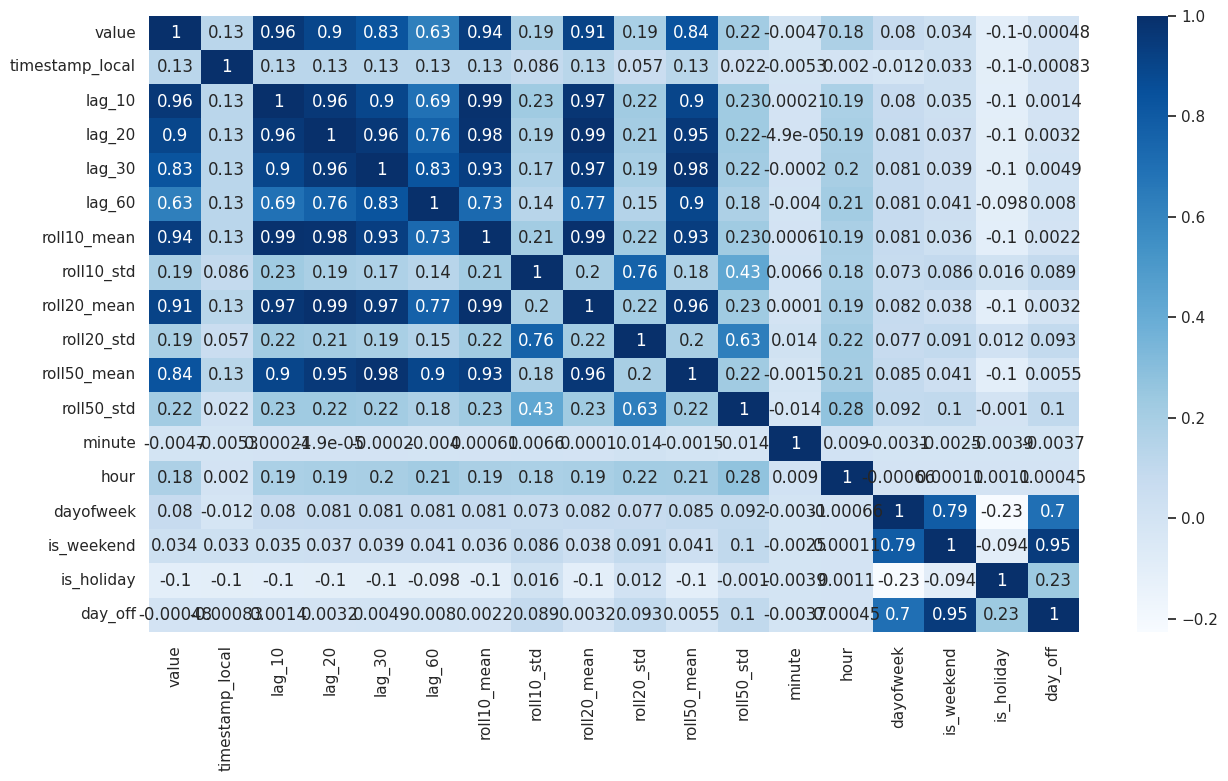

In [11]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(), cmap='Blues', annot=True);

In [12]:
# separating current value into target variable y; other features into the matrix of predicting variables
df = df.drop(columns=["timestamp_local"])
y = df["value"]
X = df.drop(columns=["value"])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [14]:
from sklearn.linear_model import LinearRegression

# Instantiate a linear regression model
linear_model = LinearRegression()

# Fit the model using the training data
linear_model.fit(X_train, y_train)

# Print out the intercept and coefficients for the linear regression model
print(linear_model.intercept_)
print(linear_model.coef_)

32.290196270330625
[ 1.24181677 -0.08985705  0.06490118  0.02302566  0.04852537 -0.66787444
 -0.19623489  0.09444761 -0.14783122  0.07486058 -0.01849235  0.097052
  0.24494632  0.41457208 -1.28705796 -0.87248588]


In [15]:
# For each record in the test set, make a prediction for the y value (transformed value of charges)
# The predicted values are stored in the y_pred array
y_pred = linear_model.predict(X_test)

In [16]:
# Metrics

from sklearn import metrics

MSE = (1 / len(y_test)) * sum ((y_test - y_pred)**2)
MAE = (1 / len(y_test)) * sum (abs(y_test - y_pred))
RSS = sum ((y_test - y_pred)**2)
TSS = sum ((y_test - y_test.mean())**2)
R_squared = 1 - (RSS/TSS)

print("\n")
print("Mean squared error (MSE) =", MSE)
print("Mean absolute error (MAE) =", MAE)
print("R^2 =", R_squared)

# The metrics package in Python can derive the model evaluation metrics
print("Mean squared error (MSE) =", metrics.mean_squared_error(y_test, y_pred))
print("Mean absolute error (MAE) =", metrics.mean_absolute_error(y_test, y_pred))
print("R^2 =", metrics.r2_score(y_test, y_pred))



Mean squared error (MSE) = 349.43080637747215
Mean absolute error (MAE) = 12.671436554877799
R^2 = 0.9262522995966536
Mean squared error (MSE) = 349.4308063774721
Mean absolute error (MAE) = 12.671436554877799
R^2 = 0.9262522995966536


So it looks to be very good at 99% but that's because the 1min is very close!
We should try it with 10 min.
After 10 min the accuracy is 0.9262522995966536.

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [18]:
# define a function to score a model

def get_acc(model, X, t):
    # 1. Get a vector of predicted results
    y_pred = model.predict(X) # uses tree.predict method

    # 2. Get a vector of actual labels - t

    # 3. acc = R squared
    acc = metrics.r2_score(t, y_pred)
    return acc

In [19]:
# define a function that selects the best tree model among models with different depths
# selection is based on model score

def select_model(depths,  criterion ):
    out = {}
    for d in depths:
        print('Evaluating on depth {}'.format(d))
        out[d] = {}
        tree = DecisionTreeRegressor(max_depth = d,criterion = criterion)
        tree.fit(X_train, y_train)
        out[d]['test'] = get_acc(tree, X_test, y_test)
        out[d]['train'] = get_acc(tree, X_train, y_train)
        out[d]['model'] = tree
    return out

In [20]:
depths = [2,5,8,9,10,15,20,30,50,70] # the depths we want to explore go in the depths list

res_sq_error = select_model(depths, "squared_error") # training models with different depths using squared error as criterion
# looping over the different models and scores to find the optimal model according to its test score
best_d_sq_error = None
best_acc_sq_error = 0

for d in res_sq_error:
    test_acc = res_sq_error[d]['test']
    print("Depth: {}   Train: {}    Test: {}".format(d, res_sq_error[d]['train'], test_acc))
    if test_acc  > best_acc_sq_error:
        best_d_sq_error = d
        best_acc_sq_error = test_acc

print('Best d (sq_error): ' + str(best_d_sq_error))
print('Best accuracy (sq_error): ' + str(best_acc_sq_error))

Evaluating on depth 2
Evaluating on depth 5
Evaluating on depth 8
Evaluating on depth 9
Evaluating on depth 10
Evaluating on depth 15
Evaluating on depth 20
Evaluating on depth 30
Evaluating on depth 50
Evaluating on depth 70
Depth: 2   Train: 0.8022526995649029    Test: 0.8055352347730335
Depth: 5   Train: 0.9175235882453149    Test: 0.916975546095222
Depth: 8   Train: 0.9337258849600885    Test: 0.9282572694840836
Depth: 9   Train: 0.9397155701387204    Test: 0.9312616039123189
Depth: 10   Train: 0.9459074703962114    Test: 0.9329978175796917
Depth: 15   Train: 0.9767229701518229    Test: 0.9397396283771409
Depth: 20   Train: 0.9923883881990473    Test: 0.9394186859127727
Depth: 30   Train: 0.9994664829563408    Test: 0.9410930781903121
Depth: 50   Train: 0.9999999731705945    Test: 0.9430865479063727
Depth: 70   Train: 1.0    Test: 0.9414697792023725
Best d (sq_error): 50
Best accuracy (sq_error): 0.9430865479063727


In [21]:
# extracting feature importances of the tree
importances = res_sq_error[best_d_sq_error]['model'].feature_importances_
tree_model = res_sq_error[best_d_sq_error]['model']

tree_importances = pd.Series(importances, index=X.columns)
print(tree_importances)

lag_10         0.919535
lag_20         0.005362
lag_30         0.004501
lag_60         0.007120
roll10_mean    0.006217
roll10_std     0.006289
roll20_mean    0.006661
roll20_std     0.006486
roll50_mean    0.009126
roll50_std     0.008030
minute         0.005861
hour           0.009259
dayofweek      0.003487
is_weekend     0.000633
is_holiday     0.000433
day_off        0.001000
dtype: float64


I removed the lags under 10 min.
The roll15 became more promising. Let's add 30 roll too.
This is the best accuracy: 0.9744115244242749.

When I added rolling over 30, it became worse.
0.9737708943769401.

By the way, this is not correct, because if you're predicting 10 minutes ahead, then you don't have access to the average of 15 before it!

Now that I shifted 10 rows to above and now only take 10 and 20 rolling averages above that point, the accuracy dropped to 0.938017820045307.

Now when I made -10, -20, -30, -60 lagged valus, and I measure the rolling means between -10 and -20, -10 and -30, -10 and -60, the accuracy bumped up a bit to 0.9421513157028315.

It's more than the linear regression results, so this set of features is promising.

Time to unpack the MLflow to track the results!
I'm still curious about the use of differences: the positive or the negative change of values, as well as the speed of the change.
